# Task 5. Audio processing. [10 pts]

<span style="color:red">__All cells of the notebook should work without errors when run consecutively.__</span>

Before starting the assignment, make this notebook `Trusted` for valid display of images:

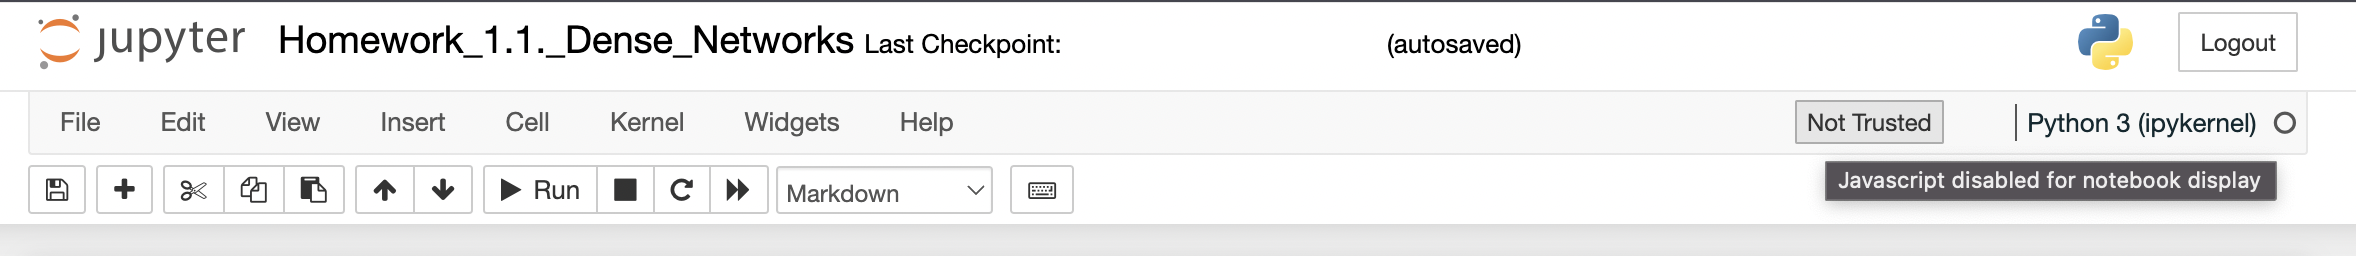

In this assignment, we will train several neural network architectures for audio classification task. We will use Mel Spectrograms as audio representations and consider transformers, 1D and 2D encoders as backbone feature extractors.

Let's start with downloading the data. We will use [ESC-50](https://github.com/karoldvl/ESC-50/) &mdash; a dataset for Environmental Sound Classification, which has 50 classes in total.

In [ ]:
%%bash
wget https://github.com/karoldvl/ESC-50/archive/master.zip
unzip master.zip

Now, let's import the libraries. If you are doing this assignment not in Google Colab, you'll probably need to install the `torchvision` package. Simply use pip for that:

```bash
pip install torchvision
```

In [ ]:
import os
import torch
import torchaudio
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from tqdm.notebook import tqdm
from torchvision.transforms import Compose
from torchaudio import transforms as T
from IPython.display import Audio

plt.rcParams.update({'font.size': 16})

Now, we load the metadata file using as `pandas` DataFrame.

In [ ]:
data_root = 'ESC-50-master/audio'
df = pd.read_csv('ESC-50-master/meta/esc50.csv')
df.head()

This is the list of all classes included in the dataset. As you can see, the classes are quite different, including both natural and mechanistic sounds.

In [ ]:
df.category.unique()

## Task 0.1. Pre-processing data [0.5 pts]

The following cell takes one random recording from the dataset and displays it as audio. You can play around with this cell and listen to different recordings. Note that all audios in this dataset have fixed length of 5 seconds.

In [ ]:
rand_row = df.sample(1).iloc[0]
audio, orig_sample_rate = torchaudio.load(os.path.join(data_root, rand_row.filename))

print(f'Filename: {rand_row.filename}')
print(f'Sample rate: {orig_sample_rate}')
print(f'Class id: {rand_row.target}')
print(f'Class name: {rand_row.category}')
print(f'Duration: {audio.shape[-1] / orig_sample_rate:.2f}s')
print(f'Audio array shape: {audio.shape}')

Audio(audio, rate=orig_sample_rate)

Moreover, all the audios of the dataset have the value of sample rate equal to 44100. [Sample rate](https://en.wikipedia.org/wiki/Sampling_(signal_processing)) is the quantity of float numbers stored for each second of the recording. Such a high value of sample rate is unnecessary for training deep learning models. The lower value of sample rate, the faster the processing. Therefore, we will manually resample our audios to sample rate  16000 (which is quite common for audio processing neural networks). We will use the `torchaudio.transform.Resample` object for this purpose.

In [ ]:
sample_rate = 16000
resampler = T.Resample(orig_freq=orig_sample_rate, new_freq=sample_rate)
resampled_audio = resampler(audio)

Various spectrograms are a common tool for representing 1D audio signal as a 2D matrix. The first dimension of a spectrogram corresponds to different frequencies, while the second dimension denotes time. We will use [Mel Spectrograms](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53), which have logarithmic scale of frequencies (they are thought to represent human's perception of audio signals better). The spectrogram represents some non-negative amplitude values, which have different magnitude orders, and thus we will apply logarithm to the spectrogram (we will also add a small addition of $10^{-9}$ to prevent taking the logarithm of zero). The `n_mels` parameter of the spectrogram controls the number of frequencies to compute (i.e., the number of features for each timestep of the spectrogram).

In [ ]:
spectrogramer = T.MelSpectrogram(sample_rate=sample_rate, n_mels=128, n_fft=600)
spec = spectrogramer(resampled_audio)[0]

plt.figure(figsize=(12, 4))
plt.imshow(torch.log(spec + 1e-9))
plt.show()

Now, we split the data into training, validation and testing subsets. We will use a stratified split so that each of three subsets has equal ratio of 50 classes and 5 folds (different sources of data used when collecting the dataset).

In [ ]:
from sklearn.model_selection import train_test_split

stratify = df.fold * 100 + df.target
train_df, test_df = train_test_split(df, test_size=0.25, stratify=stratify, random_state=0)
valid_stratify = train_df.fold * 100 + train_df.target
train_df, valid_df = train_test_split(train_df, test_size=1/6, stratify=valid_stratify, random_state=0)

train_df.shape, valid_df.shape, test_df.shape

Your task is to implement the `process_file` function. It takes the audio filename as input and applied the following processing pipeline:

1. Load the audio from the disk.
2. Resample the audio to sample rate 16000
3. Compute Mel Spectrogram of audio and apply the logarithm (add the `eps` value inside the logarithm).

**Importantly**, your output tensor should be 2D, having the shape **(n_mels, timesteps)**, so you need to remove the redundant dimension.

In [ ]:
def process_file(filename, eps=1e-9):
    """
    Process audio file
    :param  filename: path to .wav file
    :param       eps: value to stabilize logarithm computation
    :return: logarithm of spectrogram of shape (n_mels, timesteps)
    """
    # your code goes here
    pass


def process_df(df):
    y = torch.tensor(df.target.tolist())
    X = torch.stack(
        [
            process_file(os.path.join(data_root, row.filename))
            for _, row in tqdm(df.iterrows(), total=df.shape[0])
        ], dim=0
    )
    return X, y

Now, apply the processing function to all three dataframes.

In [ ]:
X_train, y_train = process_df(train_df)
X_valid, y_valid = process_df(valid_df)
X_test, y_test = process_df(test_df)

Finally, you need to initialize training, validation and testing datasets (use `TensorDataset`) and define the dataloders.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_set = ...
valid_set = ...
test_set = ...

batch_size = 32
train_loader = ...
valid_loader = ...
test_loader = ...

## Task 0.2. Implementing training loop [1 pts]

Now, implement the functions for training and evaluating the networks. Store loss and accuracy values for training and validation subsets for each epoch to plot the values during training.

- You can calculate loss and accuracy values for training set during training (i.e., no need to call `calculate_metrics` for the train dataloader at the end of epoch)
- `transform` in `train_model` is an augmentation function to use during training. This will come in handy in Task 4.
- Do not forget to make the step of `scheduler` at the end of epoch!

In [ ]:
from IPython.display import display, clear_output


@torch.no_grad()
def calculate_metrics(model, dataloader):
    """
    Calculate accuracy and loss over a dataloader
    :param       model: the model to use for predictions
    :param   dataloder: the dataloder to evaluate metrics on
    :return: loss, accuracy
    """
    # your code goes here
    pass


def plot_losses(train_loss_values, valid_loss_values, train_acc_values, valid_acc_values):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(range(1, len(train_loss_values) + 1), train_loss_values, label='train')
    axs[0].plot(range(1, len(valid_loss_values) + 1), valid_loss_values, label='valid')
    axs[1].plot(range(1, len(train_acc_values) + 1), train_acc_values, label='train')
    axs[1].plot(range(1, len(valid_acc_values) + 1), valid_acc_values, label='valid')
    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.grid()
        ax.legend()
        ax.set_xlabel('epoch')

    plt.show()


def train_model(train_loader, valid_loader, model, epochs, lr, transform=None):
        """
        :param     train_loader: the training dataloader
        :param     valid_loader: the validation dataloader
        :param            model: the model to train
        :param           epochs: the number of training epoch
        :param               lr: the value of learning rate used in optimizer
        :param        transform: the augmentation function to use during training
        """
        train_loss_values, valid_loss_values = [], []  # store loss values for each epoch here
        train_acc_values, valid_acc_values = [], []  # store accuracy values for each epoch here
        criterion = ...
        optimizer = ...
        scheduler = ...  # use torch.optim.lr_scheduler.CosineAnnealingLR as a scheduler

        for epoch in range(1, epochs + 1):
            ### TRAINING ###
            model.train()

            for data, labels in train_loader:
                if torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()

                if transform is not None:
                    data = transform(data)

                # your code goes here

            # your code goes here

            ### VALIDATING ###
            model.eval()
            # your code goes here

            if epoch % 5 == 0:
                plot_losses(
                    train_loss_values, valid_loss_values,
                    train_acc_values, valid_acc_values
                )

            torch.cuda.empty_cache()


def get_num_params(model):
    return sum(param.numel() for param in model.parameters())


def evaluate_model(classifier, model_name=None, eval_df=None):
    if eval_df is None:
        eval_df = pd.DataFrame(columns=['Model', 'Params Number', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy'])

    if model_name is None:
        model_name = classifier.__class__.__name__

    _, train_accuracy = calculate_metrics(classifier, train_loader)
    _, validation_accuracy = calculate_metrics(classifier, valid_loader)
    _, test_accuracy = calculate_metrics(classifier, test_loader)
    num_params = get_num_params(classifier)

    eval_df = eval_df.append({
        'Model': model_name, 'Params Number': num_params, 'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy, 'Validation Accuracy': validation_accuracy
    }, ignore_index=True)

    display(eval_df)
    return eval_df

## Task 1. Attention Classifier [2.5 pts]

We will start our experiments with transformer-like model. Use several (`n_layers`) consecutive layers of `nn.TransformerEncoderLayer` as a backbone. Then, take the resulting representations outputted by transformer layers and average them over the length dimension (i.e., Global Average Pooling). Finally, use a linear classification head. The dimensionality of encoder layers should be the same as `n_mels`, as we treat our spectrogram as a sequence of feature vectors (i.e., each feature is a frequency).

In [ ]:
class AttentionClassifier(nn.Module):
    def __init__(self, n_layers=1, d_model=128, dim_feedforward=2048, nhead=16):
        """
        Model based on nn.TransformerEncoderLayer
        :param         n_layers: number of nn.TransformerEncoderLayer layers
        :param          d_model: number of spectrogram features (n_mels)
        :param  dim_feedforward: the corresponding parameter for nn.TransformerEncoderLayer
        :param           n_head: the corresponding parameter for nn.TransformerEncoderLayer
        """
        super(AttentionClassifier, self).__init__()
        # your code goes here
        pass

    def forward(self, x):
        # your code goes here
        pass

Initialize the `AttentionClassifier` with default parameters. Feel free to use the validation set to find appropriate values of `epochs` and `lr` (i.e., we do not ask you to launch the full grid search for these hyperparameters, just play around and find the values performing good).

In [ ]:
classifier = AttentionClassifier()
print(f'{classifier.__class__.__name__} has {get_num_params(classifier)} parameters')

if torch.cuda.is_available():
    classifier = classifier.cuda()

In [ ]:
train_model(train_loader, valid_loader, classifier, epochs=..., lr=...)

In [ ]:
eval_df = evaluate_model(classifier, eval_df=None)

If you have done everything right, you'll have the test accuracy $\approx 60\%$.

## Task 2. 1D Convolutional Encoder [2.5 pts]

The next step is to try convolutional backbones. We will start with 1D convolutions, which are popular for audio processing. We will treat the frequencies as the channels dimensionality and apply the 1D convolutions over the time dimensionality.

First of all, you need to implement a `ResBlock1D`, similar to blocks of regular ResNet. The scheme of block is presented in the image below. The block takes a features map having `in_channels` channels, each convolution has `out_channels` number of output channels. The convolution parameters are shown in the image.

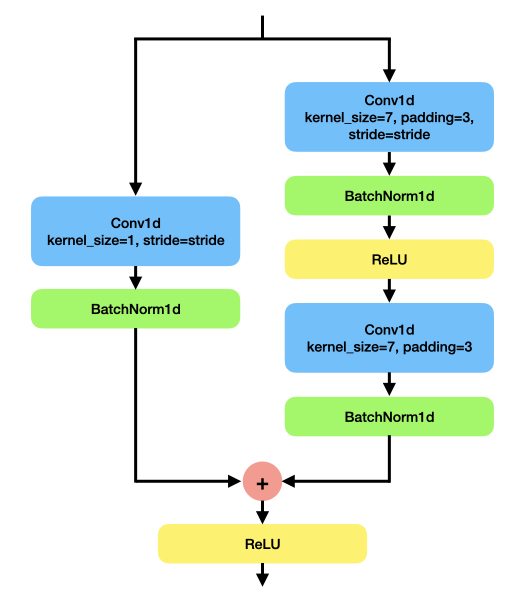

Once the `ResBlock1D` is implemented, we can assembly the whole network. It will consist of 4 sequential blocks. We will make the width of the network variable using the `width_factor` parameter:

1. `in_channels=128` (equal to `n_mels`), `out_channels=width_factor`, `stride=2`
2. `in_channels=width_factor`, `out_channels=width_factor * 2`, `stride=2`
3. `in_channels=width_factor * 2`, `out_channels=width_factor * 4`, `stride=2`
4. `in_channels=width_factor * 4`, `out_channels=width_factor * 8`, `stride=2`

Then, average the resulting feature maps over the time dimension (Global Average Pooling) and apply the linear classification layer.

**Important!** Do not forget to set `bias=False` for convolutions before the batch normalization layers, as the bias will be useless because of the normalization operation.

In [ ]:
class ResBlock1D(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock1D, self).__init__()
        # your code goes here
        pass

    def forward(self, x):
        # your code goes here
        pass


class CNNClassifier1D(torch.nn.Module):
    def __init__(self, in_channels=128, width_factor=16):
        super(CNNClassifier1D, self).__init__()
        # your code goes here
        pass

    def forward(self, x):
        # your code goes here
        pass

We want a fair comparison of different architectures, so we will try to keep the same number of parameters as we had in `AttentionClassifier`. Find such value of `width_factor` so that the difference in number of parameters is less then $10\%$.

In [ ]:
classifier = CNNClassifier1D(width_factor=...)
print(f'{classifier.__class__.__name__} has {get_num_params(classifier)} parameters')

if torch.cuda.is_available():
    classifier = classifier.cuda()

And again, feel free to tune the `epochs` and `lr` using the validation set.

In [ ]:
train_model(train_loader, valid_loader, classifier, epochs=..., lr=...)

In [ ]:
eval_df = evaluate_model(classifier, eval_df=eval_df)

If you have done everything right, you'll have the test accuracy $\approx 60 \%$.

## Task 3. 2D Convolutional Encoder [2.5 pts]

Finally, we will treat our spectrograms as images, which have one color channel, and use 2D convolutions to process them. Take the convolutional architecture from the previous part and replace $1\times 7$ convolutions with $3\times 3$ convolutions (but keep the $1\times 1$ convolutions in the residual connection as is). Also set `padding=1` for $3\times 3$ convolutions. Do not forget to switch `nn.BatchNorm1d` to `nn.BatchNorm2d`.

**Important!** We will treat spectrograms as images having one color channel, so don't forget to add this channels, i.e., you will need to resize `(batch_size, n_mels, timesteps)` tensor to `(batch_size, 1, n_mels, timesteps)`.

In [ ]:
class ResBlock2D(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock2D, self).__init__()
        # your code goes here
        pass

    def forward(self, x):
        # your code goes here
        pass


class CNNClassifier2D(torch.nn.Module):
    def __init__(self, width_factor=16):
        super(CNNClassifier2D, self).__init__()
        # your code goes here
        pass

    def forward(self, x):
        # your code goes here
        pass

Again, find such value of `width_factor` so that the difference to `AttentionClassifier` in number of parameters is less then $10\%$.

In [ ]:
classifier = CNNClassifier2D(width_factor=...)
print(f'{classifier.__class__.__name__} has {get_num_params(classifier)} parameters')

if torch.cuda.is_available():
    classifier = classifier.cuda()

And again, feel free to tune the `epochs` and `lr` using the validation set.

In [ ]:
train_model(train_loader, valid_loader, classifier, epochs=..., lr=...)

In [ ]:
eval_df = evaluate_model(classifier, eval_df=eval_df)

If you have done everything right, you'll have the test accuracy $\ge 72 \%$.

## Task 4. Adding augmentations [1 pts]

One final step is to add augmentations to spectrograms to make the network more robust and improve the test quality. We will use two types of augmentations: [`torchvision.transforms.FrequencyMasking`](https://pytorch.org/audio/stable/generated/torchaudio.transforms.FrequencyMasking.html#torchaudio.transforms.FrequencyMasking) and [`torchvision.transforms.TimeMasking`,](https://pytorch.org/audio/stable/generated/torchaudio.transforms.TimeMasking.html#torchaudio.transforms.TimeMasking) which mask out horizontal and vertical regions of the spectrogram. Take the best performing architecture (should be `CNNClassifier2D`) and use the validation set to find the best parameters for these augmentations. Then, train the final model.

In [ ]:
transform = ...

In [ ]:
classifier = CNNClassifier2D(width_factor=...)
print(f'{classifier.__class__.__name__} has {get_num_params(classifier)} parameters')

if torch.cuda.is_available():
    classifier = classifier.cuda()

In [ ]:
train_model(train_loader, valid_loader, classifier, epochs=..., lr=..., transform=transform)

In [ ]:
eval_df = evaluate_model(classifier, model_name='CNNClassifier2D + aug', eval_df=eval_df)

If you have done everything right, you'll have the test accuracy $\ge 76 \%$.